In [1]:
import matplotlib.pyplot as plt
import mpmath as mp
mp.mp.dps = 30 #higher precision
import pandas as pd
from PyMatching import *
import json
import scipy
import os

In [2]:

def calculate_curve(df: pd.DataFrame, energy_type):
    """
    Calculate the success curve and its components (lower and upper bounds)
    for the specified energy type ('nish_temp' or 'low_temp').
    """
    curve = mp.mpf(1)

    for _, df_run in df.groupby('histogram_seed'):
        free_energy_I = df_run.loc[df_run['error'] == '0000', f'free_energy_{energy_type}'].values[0]
        other_errors = df_run.loc[df_run['error'] != '0000', f'free_energy_{energy_type}']

        # Update the curve based on the condition
        curve -= mp.mpf(int((free_energy_I < other_errors).any())) / (mp.mpf(len(df))/16) # 16 is needed here as len is num error classes * num interaction seeds but we want to normalize only by sample size given by interaction samples

    return curve

def calculate_bounds(curve, successes, failures):
    """
    Calculate the lower and upper bounds for the curve using a beta distribution.
    """
    lower_bound = curve - scipy.stats.beta.ppf(0.025, 0.5 + successes, 0.5 + failures)
    upper_bound = scipy.stats.beta.ppf(0.975, 0.5 + successes, 0.5 + failures) - curve
    return lower_bound, upper_bound


def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)

    except json.JSONDecodeError as e:
        raise RuntimeError(f"Failed to parse JSON: {e}")


    return data

def process_data(data, batch_results, p, X, Y, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append(
            {
                "prob": p,
                "X": X,
                "Y": Y,
                "error": error,
                "histogram_seed": histogram_seed,
                "run_seed": run_seed,
                "E": E_list,
                "log_g": log_g_list,
            }
        )

def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value - maxval)
    res = maxval + mp.log(exp_sum)
    return res

def rescale_log_g(row):
    log_g_list = row["log_g"]
    X = row["X"]
    Y = row["Y"]

    offset = log_sum_exp(log_g_list)

    rescaled_log_g_list = [
        res + mp.log(2)*X*Y - offset for res in log_g_list
    ]

    return rescaled_log_g_list

# Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list, T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i] / T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value - maxval)
    res = maxval + mp.log(exp_sum)
    return -T * res

In [3]:
# read eight vertex bitflip limit results
results_df = pd.DataFrame()

batch_results = []

low_temp=1e-20
high_temp=1e20

probabilities = [0.03, 0.05, 0.06, 0.08]
sizes = [4, 6]
intervals = [16]
iterations = 10000
overlap = 0.25
walkers = 4
alpha = 0.8
beta = 1e-8
exchange = 20
errors = ["0000", "1000", "0100", "0010", "0001", "1100", "1010", "1001", "0110", "0101", "0011", "1110", "1101", "1011", "0111", "1111"]

for interval in intervals:
    for p in probabilities:
        for size in sizes:
            for error in errors:
                filename = f"../results/eight_vertex/periodic/qubit_specific_noise_0/prob_x_{p:.6f}/prob_y_{p:.6f}/prob_z_{p:.6f}/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram__intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset_{exchange}.txt"
                if os.path.exists(filename):
                    try:
                        data = read_results_file(filename)
                        if data:
                            process_data(data, batch_results, p, size, size, error)
                    except:
                        continue
                else:
                    print(f"filename does not exist {filename}")


df = pd.DataFrame(batch_results)

print(len(batch_results))


1264698


In [4]:
# Filter based on errors
df_filtered = df.groupby(["histogram_seed", "prob", "X", "Y"]).filter(
    lambda x: len(x) == len(errors)
)

df_filtered['rescaled_log_g'] = df_filtered.apply(rescale_log_g, axis=1)


In [5]:
df_filtered_copy = df_filtered.copy()

In [6]:
scale_factors = {'prob': [], 'scale_factor': []}

for p in probabilities:
    filename = f"../results/eight_vertex/J_scale/periodic/qubit_specific_noise_0/prob_X_{p:.6f}_prob_Y_{p:.6f}_prob_Z_{p:.6f}/scale.txt"
    if os.path.exists(filename):
        try:
            with open(filename, 'r') as file:
                factor = file.read().strip()
                scale_factors["prob"].append(p)
                scale_factors["scale_factor"].append(factor)
        except:
            continue

df_scale_factors = pd.DataFrame(scale_factors)

In [7]:
df_filtered_copy_joined = df_filtered_copy.merge(df_scale_factors, on='prob', how='left')

if df_filtered_copy_joined['scale_factor'].isnull().any():
    print("Warning: Some rows have missing scale factors. These will not be scaled.")

df_filtered_copy_joined['scale_factor'] = pd.to_numeric(df_filtered_copy_joined['scale_factor'], errors='coerce')

# Rescale each entry in 'E' by the corresponding 'scale_factor'
df_filtered_copy_joined['E_rescaled'] = df_filtered_copy_joined.apply(lambda row: [e / row['scale_factor'] for e in row['E']], axis=1)


In [8]:
df_filtered_copy = df_filtered_copy_joined

In [9]:
display(df_filtered_copy)

,prob,X,Y,error,histogram_seed,run_seed,E,log_g,rescaled_log_g,scale_factor,E_rescaled
0,0.03,4,4,0000,1566,1,"[-96, -80, -72, -64, -56, -48, -40, -32, -24, ...","[0.0, 3.520132407546043, 4.891345247626305, 7....","[-9.80227122875529750119218919818, -6.28213882...",1.17225,"[-81.8937939859245, -68.24482832160375, -61.42..."
1,0.03,4,4,0000,4929,1,"[-96, -80, -72, -64, -56, -48, -40, -32, -24, ...","[0.0, 3.472670063376427, 4.881237495690584, 7....","[-9.70924651562783114449184411374, -6.23657645...",1.17225,"[-81.8937939859245, -68.24482832160375, -61.42..."
2,0.03,4,4,0000,3307,1,"[-96, -80, -72, -64, -56, -48, -40, -32, -24, ...","[0.0, 3.484769899398088, 4.841554690152407, 6....","[-9.55126096136236879167473901848, -6.06649106...",1.17225,"[-81.8937939859245, -68.24482832160375, -61.42..."
3,0.03,4,4,0000,3860,1,"[-96, -80, -72, -64, -56, -48, -40, -32, -24, ...","[0.0, 3.410799093544483, 4.769982364028692, 6....","[-9.66982210756684979283891806024, -6.25902301...",1.17225,"[-81.8937939859245, -68.24482832160375, -61.42..."
4,0.03,4,4,0000,1597,1,"[-96, -80, -72, -64, -56, -48, -40, -32, -24, ...","[0.0, 3.443414252251387, 4.818188320845366, 6....","[-9.65615961756805452101689246856, -6.21274536...",1.17225,"[-81.8937939859245, -68.24482832160375, -61.42..."
...,...,...,...,...,...,...,...,...,...,...,...
1076091,0.08,6,6,1111,9292,128,"[-144, -140, -136, -132, -128, -124, -120, -11...","[0.0, 3.952687837183475, 7.058618910610676, 9....","[-21.7739172097595265572014033763, -17.8212293...",1.77676,"[-81.04639906346384, -78.79511020058985, -76.5..."
1076092,0.08,6,6,1111,9485,128,"[-144, -140, -136, -132, -128, -124, -120, -11...","[0.0, 4.51294294372201, 7.813533019274473, 10....","[-23.5062918689204085411100256166, -18.9933489...",1.77676,"[-81.04639906346384, -78.79511020058985, -76.5..."
1076093,0.08,6,6,1111,7279,128,"[-144, -140, -136, -132, -128, -124, -120, -11...","[0.0, 3.623677857220173, 7.082091551274061, 9....","[-22.4095281683010979157329824102, -18.7858503...",1.77676,"[-81.04639906346384, -78.79511020058985, -76.5..."
1076094,0.08,6,6,1111,5931,128,"[-144, -140, -136, -132, -128, -124, -120, -11...","[0.0, 4.585886977612972, 7.820640195161104, 10...","[-22.4297923282164144343466766208, -17.8439053...",1.77676,"[-81.04639906346384, -78.79511020058985, -76.5..."


In [10]:
df_sorted = df_filtered_copy.sort_values(by=["X", "Y", "prob", "histogram_seed", "error"])

df_sorted[f"free_energy_nish_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], 1/(mp.log((1-row['prob'])/row['prob'])/2))/(-1/(mp.log((1-row['prob'])/row['prob'])/2)), axis=1)

In [11]:
df_sorted[f"free_energy_nish_temp_non_rescaled"] = df_sorted.apply(lambda row: free_energy(row['E'], row['rescaled_log_g'], 1/(mp.log((1-row['prob'])/row['prob'])/2))/(-1/(mp.log((1-row['prob'])/row['prob'])/2)), axis=1)

In [12]:
df_sorted['diff_free_energy'] = df_sorted["free_energy_nish_temp"] - df_sorted["free_energy_nish_temp_non_rescaled"]

In [13]:
df_sorted[f"free_energy_low_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], low_temp)/(-low_temp), axis=1)

In [14]:
df_sorted[f"free_energy_high_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], high_temp)/(-high_temp), axis=1)

In [15]:
df_sorted[f"free_energy_doubled_nish_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], 2/(mp.log((1-row['prob'])/row['prob'])/2))/(-2/(mp.log((1-row['prob'])/row['prob'])/2)), axis=1)

In [16]:
df_sorted["free_energy_eight_times_nish_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], 8/(mp.log((1-row['prob'])/row['prob'])/2))/(-8/(mp.log((1-row['prob'])/row['prob'])/2)), axis=1)

In [26]:
df_sorted[f"free_energy_nish_three_times_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], 3/(mp.log((1-row['prob'])/row['prob'])/2))/(-3/(mp.log((1-row['prob'])/row['prob'])/2)), axis=1)

In [27]:
df_sorted[f"free_energy_nish_four_times_temp"] = df_sorted.apply(lambda row: free_energy(row['E_rescaled'], row['rescaled_log_g'], 4/(mp.log((1-row['prob'])/row['prob'])/2))/(-4/(mp.log((1-row['prob'])/row['prob'])/2)), axis=1)

In [28]:
grouped_df = df_sorted.copy()

results = []

for (prob, X, Y), group in grouped_df.groupby(['prob', 'X', 'Y']):
    curve_value_low_temp = calculate_curve(group, "low_temp")
    curve_value_nishimori_temp = calculate_curve(group, "nish_temp")
    curve_value_nishimori_temp_non_rescaled = calculate_curve(group, "nish_temp_non_rescaled")
    curve_value_doubled_nishimori_temp = calculate_curve(group, "doubled_nish_temp")
    curve_value_three_times_nishimori_temp = calculate_curve(group, "nish_three_times_temp")
    curve_value_four_times_nishimori_temp = calculate_curve(group, "nish_four_times_temp")
    curve_value_eight_times_nishimori_temp = calculate_curve(group, "eight_times_nish_temp")
    curve_value_high_temp = calculate_curve(group, "high_temp")

    results.append((prob, X, Y, curve_value_low_temp, curve_value_nishimori_temp, curve_value_high_temp, curve_value_doubled_nishimori_temp, curve_value_three_times_nishimori_temp, curve_value_four_times_nishimori_temp, curve_value_eight_times_nishimori_temp, curve_value_nishimori_temp_non_rescaled))

results_df = pd.DataFrame(results, columns=['prob', 'X', 'Y', 'low_temp_curve', 'nishimori_temp_curve', 'high_temp_curve', 'doubled_nishimori_temp_curve', 'three_times_nishimori_temp_curve','four_times_nishimori_temp_curve','eight_times_nishimori_temp_curve', 'nishimori_temp_curve_non_rescaled'])


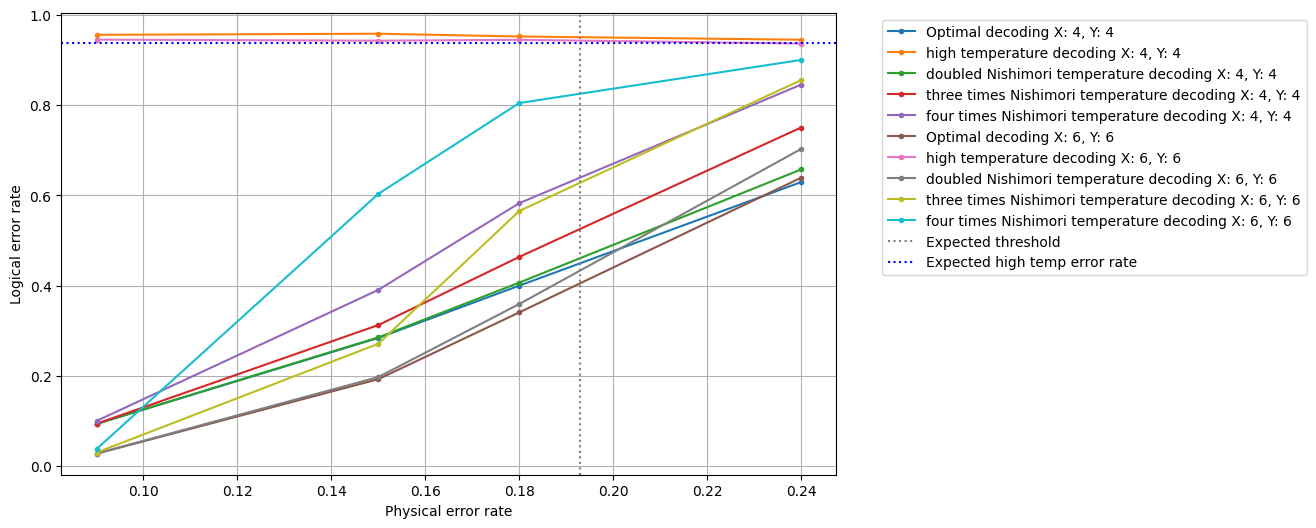

In [31]:

plt.figure(figsize=(10, 6))

for (X, Y), group in results_df.groupby(['X', 'Y']):
    plt.plot(3*group['prob'], 1-group['nishimori_temp_curve'], ".-", label=f'Optimal decoding X: {X}, Y: {Y}')
    # plt.plot(3*group['prob'], 1-group['nishimori_temp_curve_non_rescaled'], "+--", label=f'Optimal decoding X: {X}, Y: {Y}')
    # plt.plot(3*group['prob'], 1-group['low_temp_curve'], "+--", label=f'low temperature decoding X: {X}, Y: {Y}')
    plt.plot(3*group['prob'], 1-group['high_temp_curve'], ".-", label=f'high temperature decoding X: {X}, Y: {Y}')
    plt.plot(3*group['prob'], 1-group['doubled_nishimori_temp_curve'], ".-", label=f'doubled Nishimori temperature decoding X: {X}, Y: {Y}')
    plt.plot(3*group['prob'], 1-group['three_times_nishimori_temp_curve'], ".-", label=f'three times Nishimori temperature decoding X: {X}, Y: {Y}')
    plt.plot(3*group['prob'], 1-group['four_times_nishimori_temp_curve'], ".-", label=f'four times Nishimori temperature decoding X: {X}, Y: {Y}')
    # plt.plot(3*group['prob'], 1-group['eight_times_nishimori_temp_curve'], "+--", label=f'eight times Nishimori temperature decoding X: {X}, Y: {Y}')


plt.axvline(x=0.193,color="gray",label="Expected threshold",linestyle="dotted")
plt.axhline(y=1-1/16,color="blue",label="Expected high temp error rate",linestyle="dotted")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()